In [21]:
import sys
import os
import json
import xml_writers as writers
from xml.dom import minidom
import xml.etree.ElementTree as ET

linprog_scripts_dir = os.path.abspath('/home/sfischer/Documents/projects/wk_LinProg/LinProg_Scripts')
sys.path.append(linprog_scripts_dir)

import pickle
from LinProg_lib import *

# ======================================================================
# Load the original Task graph of the workload
# ======================================================================
with open('/home/sfischer/Documents/projects/wk_LinProg/LinProg_Scripts/Task_graph.pkl', 'rb') as file:
    task_graph = pickle.load(file)


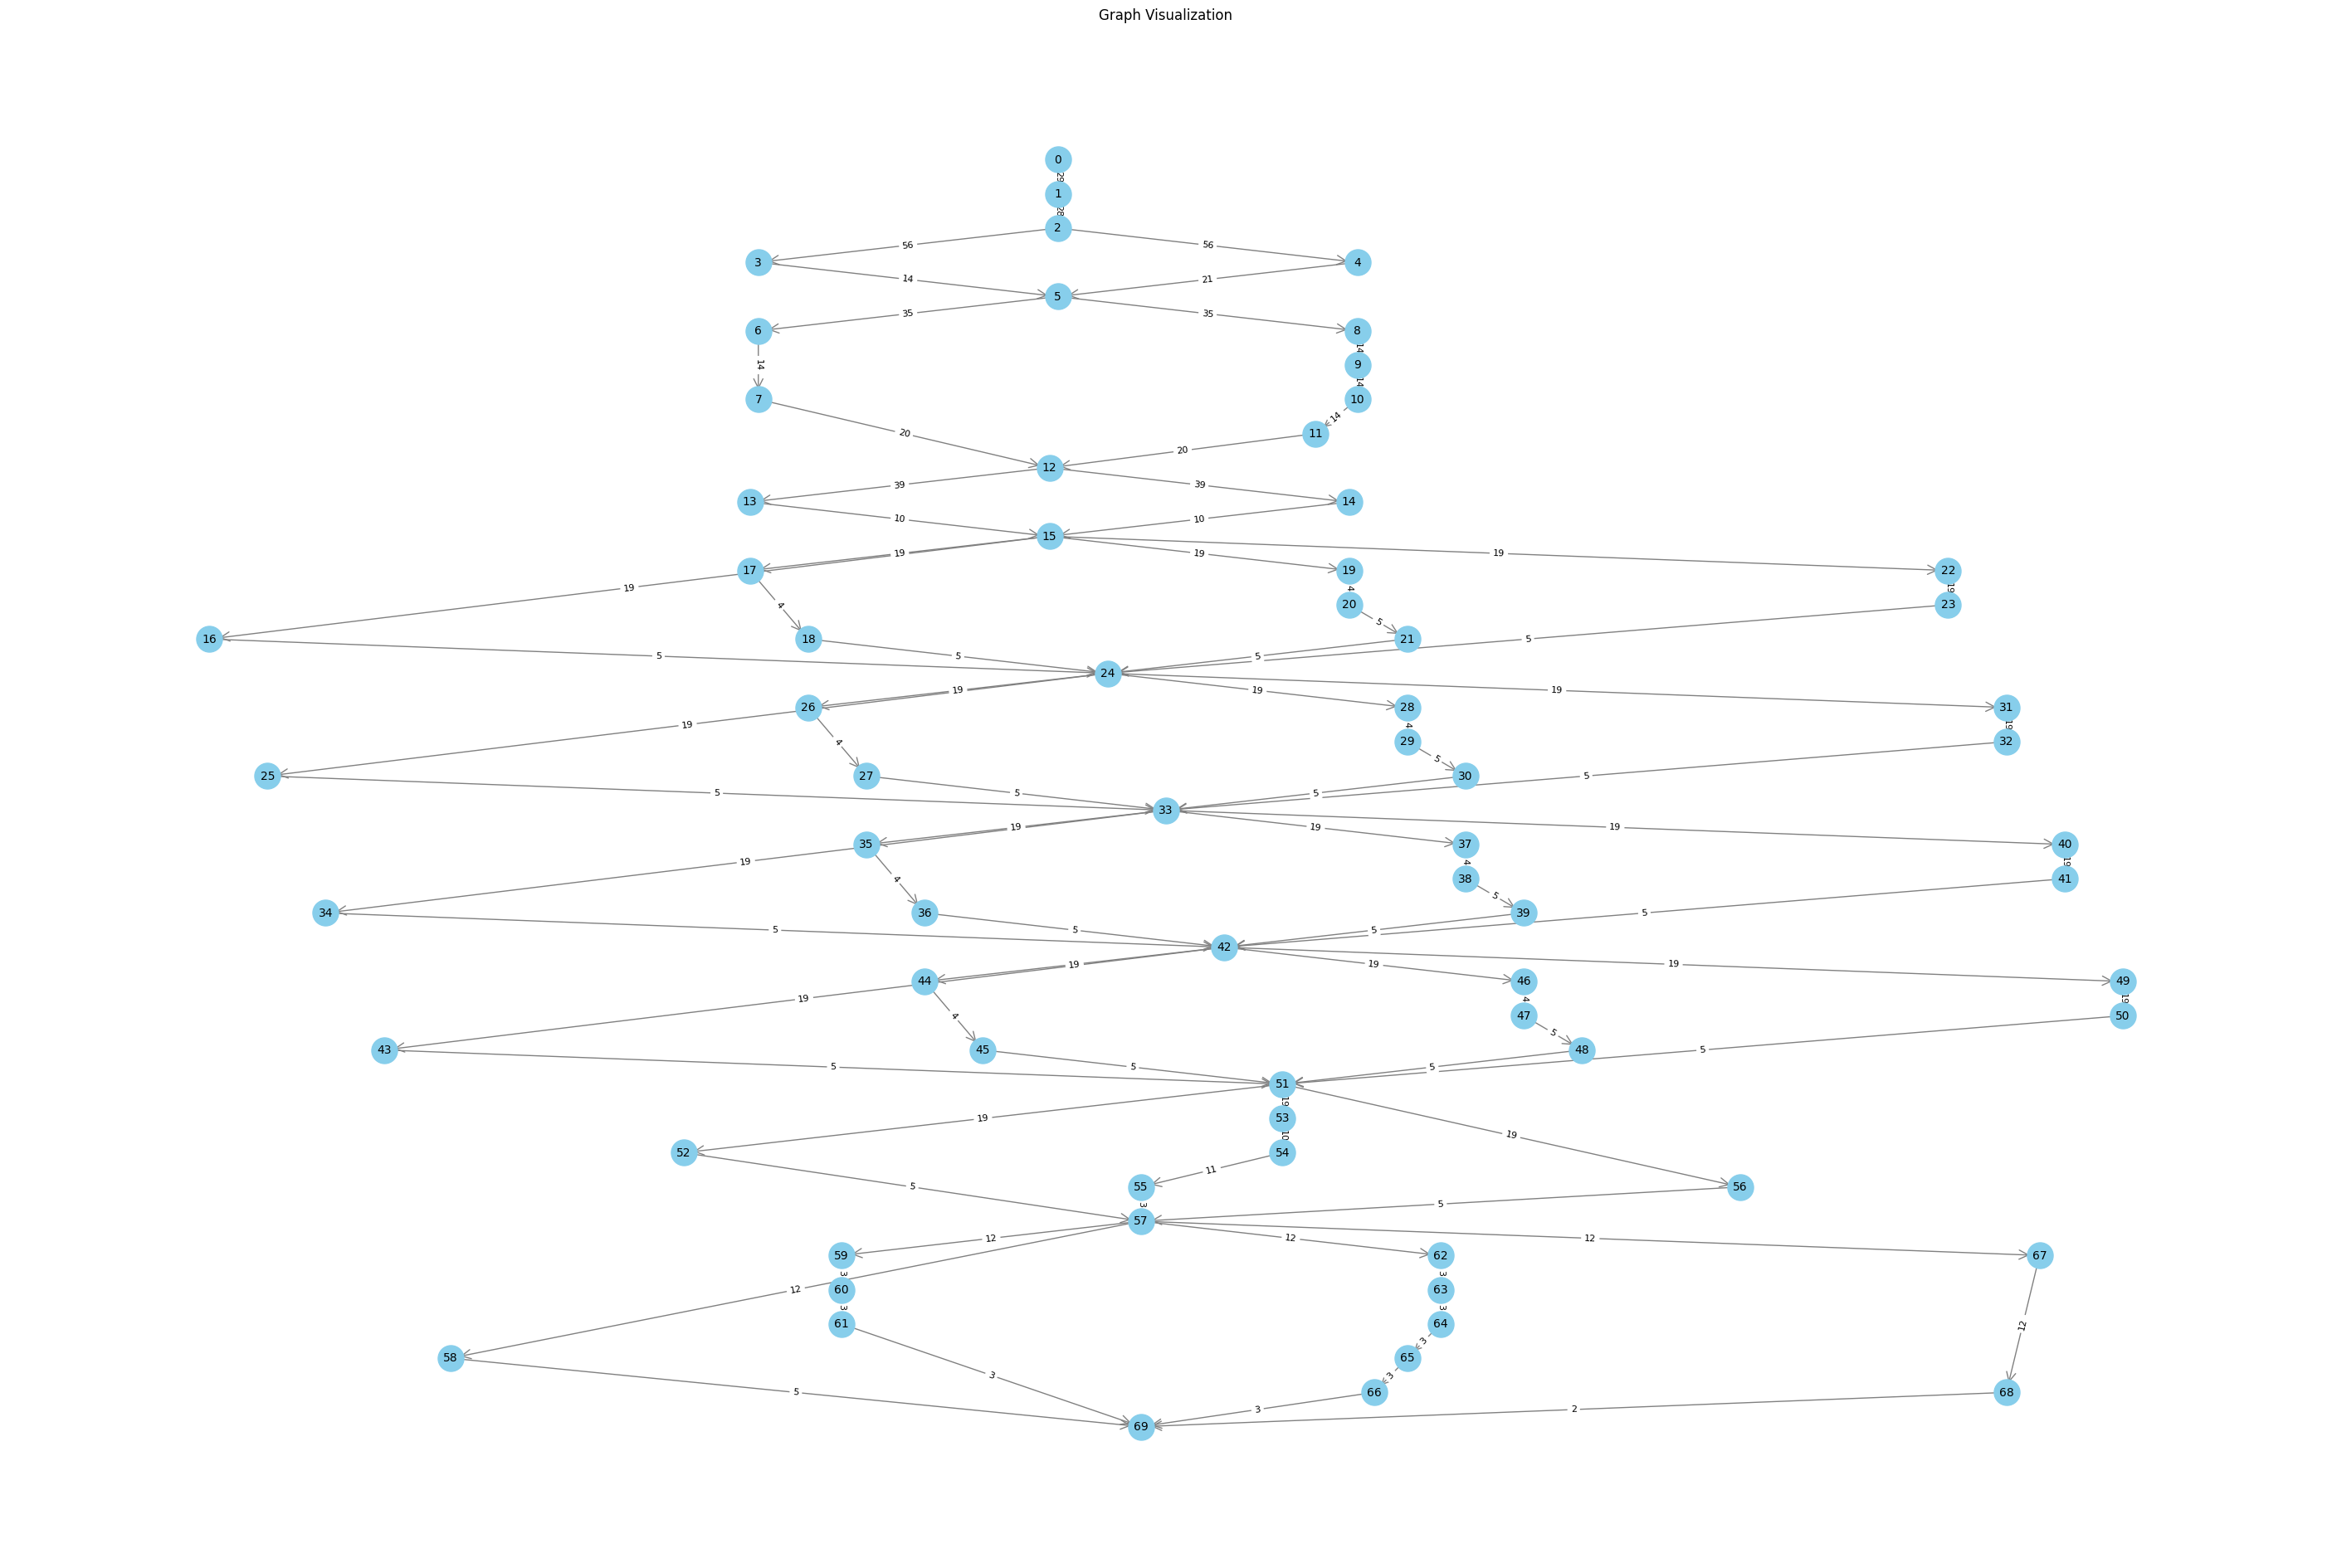

In [22]:
draw_networkx_graph(task_graph)

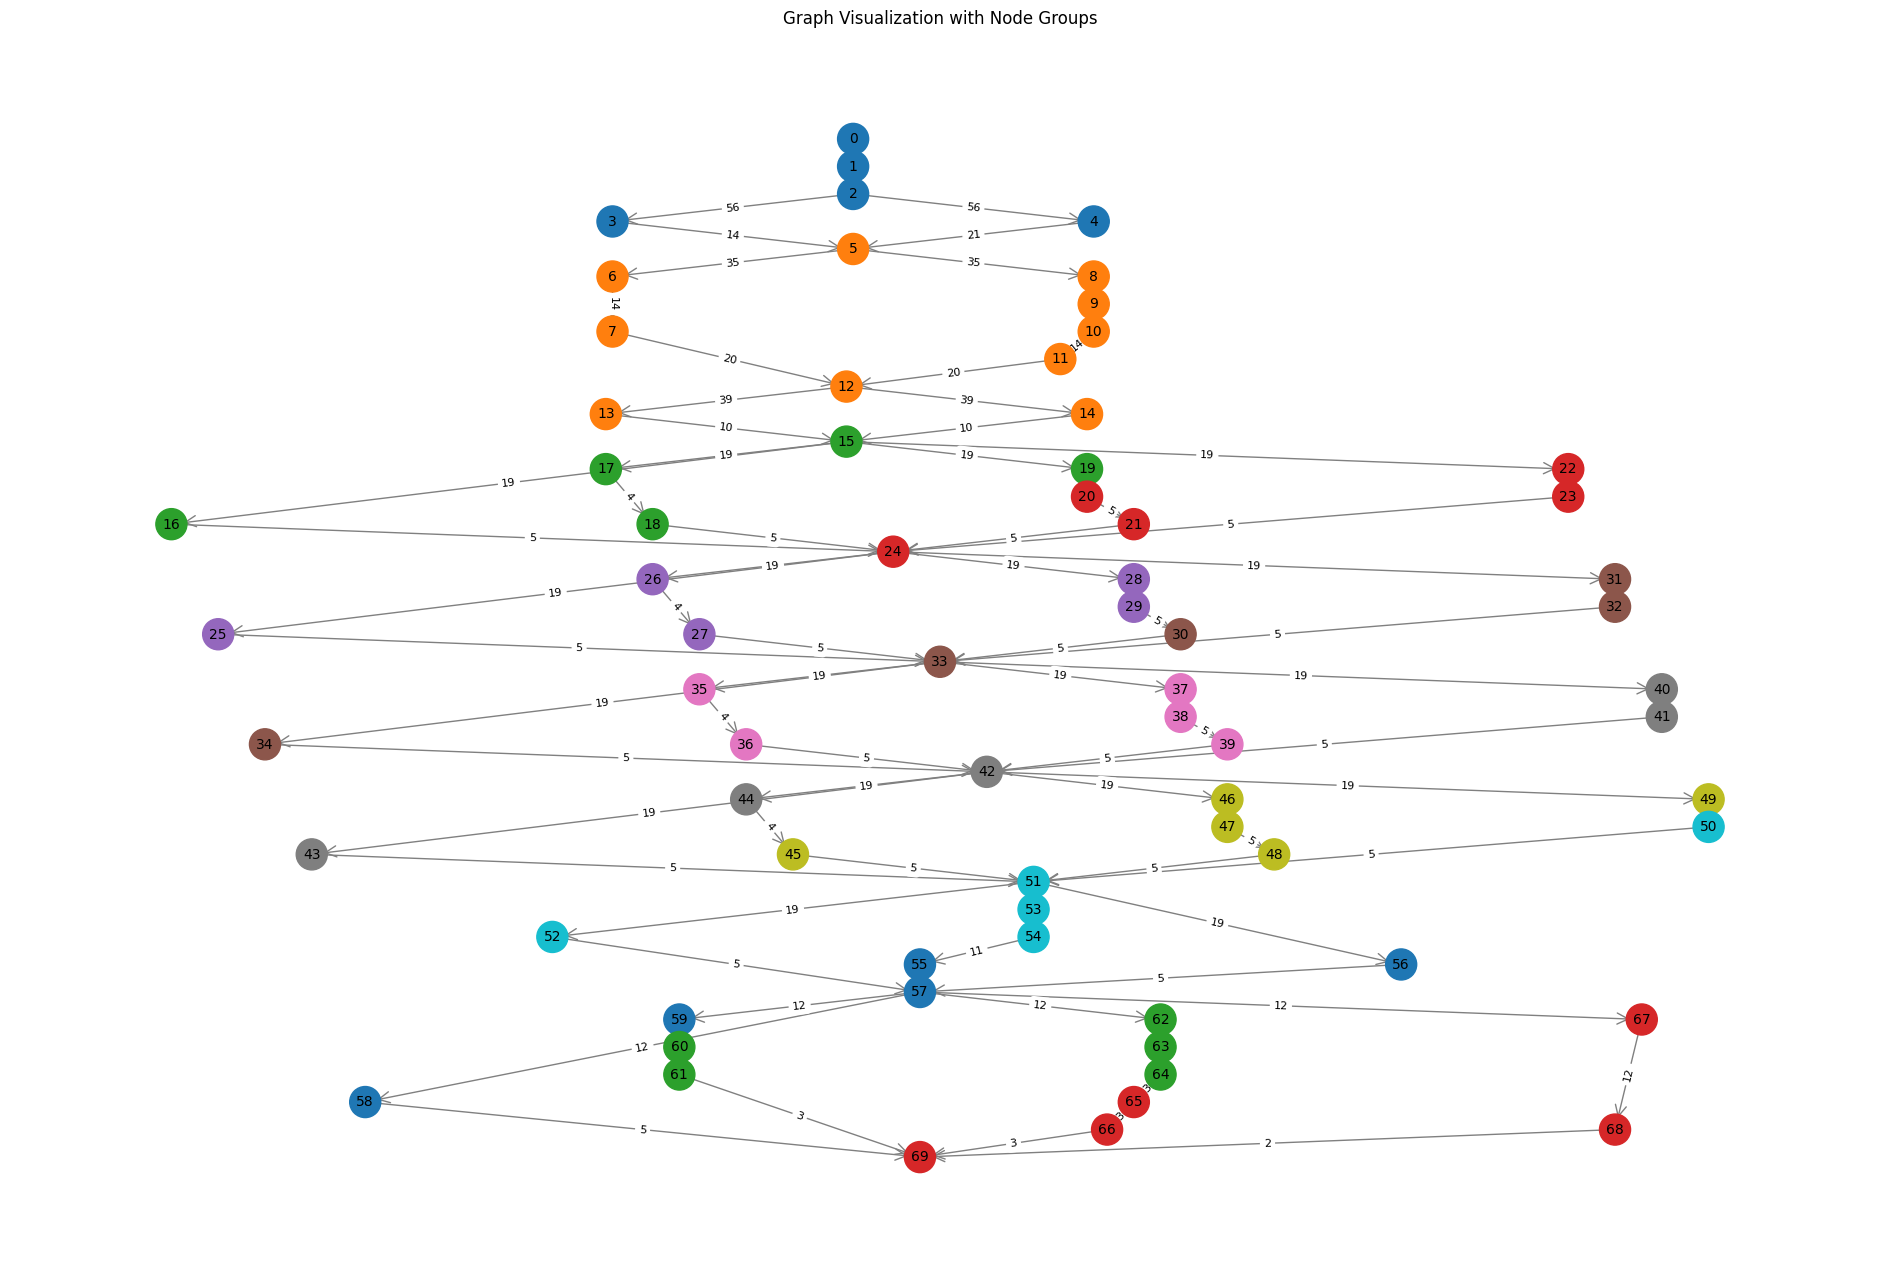

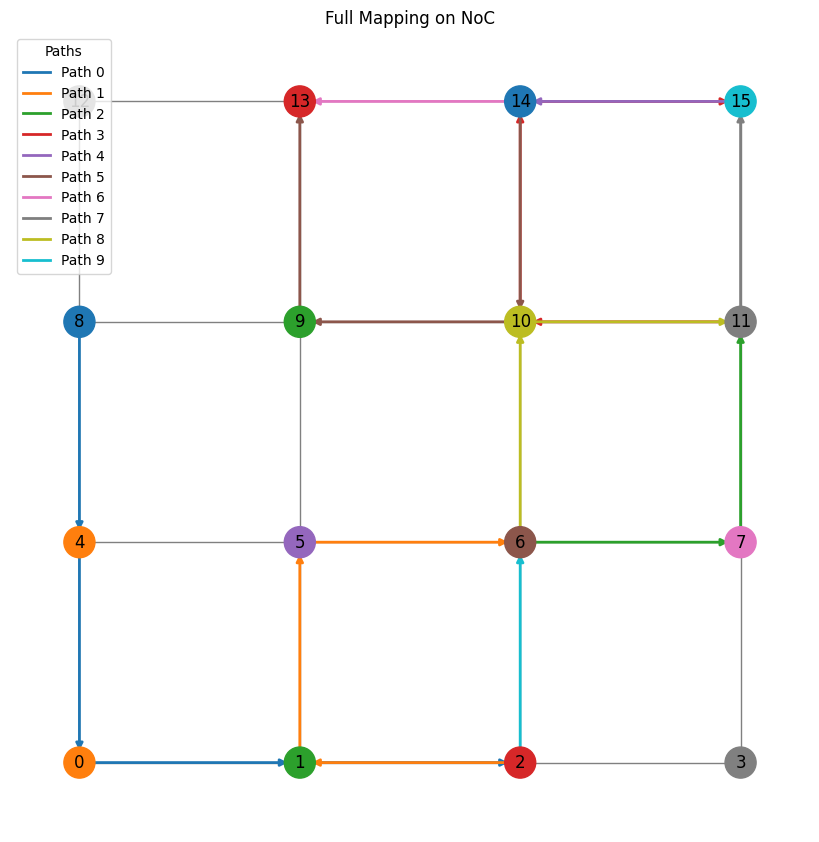

{'35': 7, '5': 4, '10': 0, '45': 10, '15': 1, '25': 5, '60': 9, '20': 2, '30': 6, '40': 11, '50': 15, '55': 14, '65': 13, '0': 8}
{'0': [0, 1, 2, 3, 4], '10': [10, 11, 12, 13, 14], '15': [15, 16, 17, 18, 19], '20': [20, 21, 22, 23, 24], '25': [25, 26, 27, 28, 29], '30': [30, 31, 32, 33, 34], '35': [35, 36, 37, 38, 39], '40': [40, 41, 42, 43, 44], '45': [45, 46, 47, 48, 49], '50': [50, 51, 52, 53, 54], '55': [55, 56, 57, 58, 59], '5': [5, 6, 7, 8, 9], '60': [60, 61, 62, 63, 64], '65': [65, 66, 67, 68, 69]}
Independent paths for accelerator [[0, 1, 2, 3], [0, 1, 2, 4]]:
Independent paths for accelerator [[10, 11, 12, 13], [10, 11, 12, 14]]:
Independent paths for accelerator [[15, 16], [15, 17, 18], [15, 19]]:
Independent paths for accelerator [[20, 21, 24], [22, 23, 24]]:
Independent paths for accelerator [[26, 27], [28, 29]]:
Independent paths for accelerator [[30, 33, 34], [31, 32, 33, 34]]:
Independent paths for accelerator [[35, 36], [37, 38, 39]]:
Independent paths for accelerator [

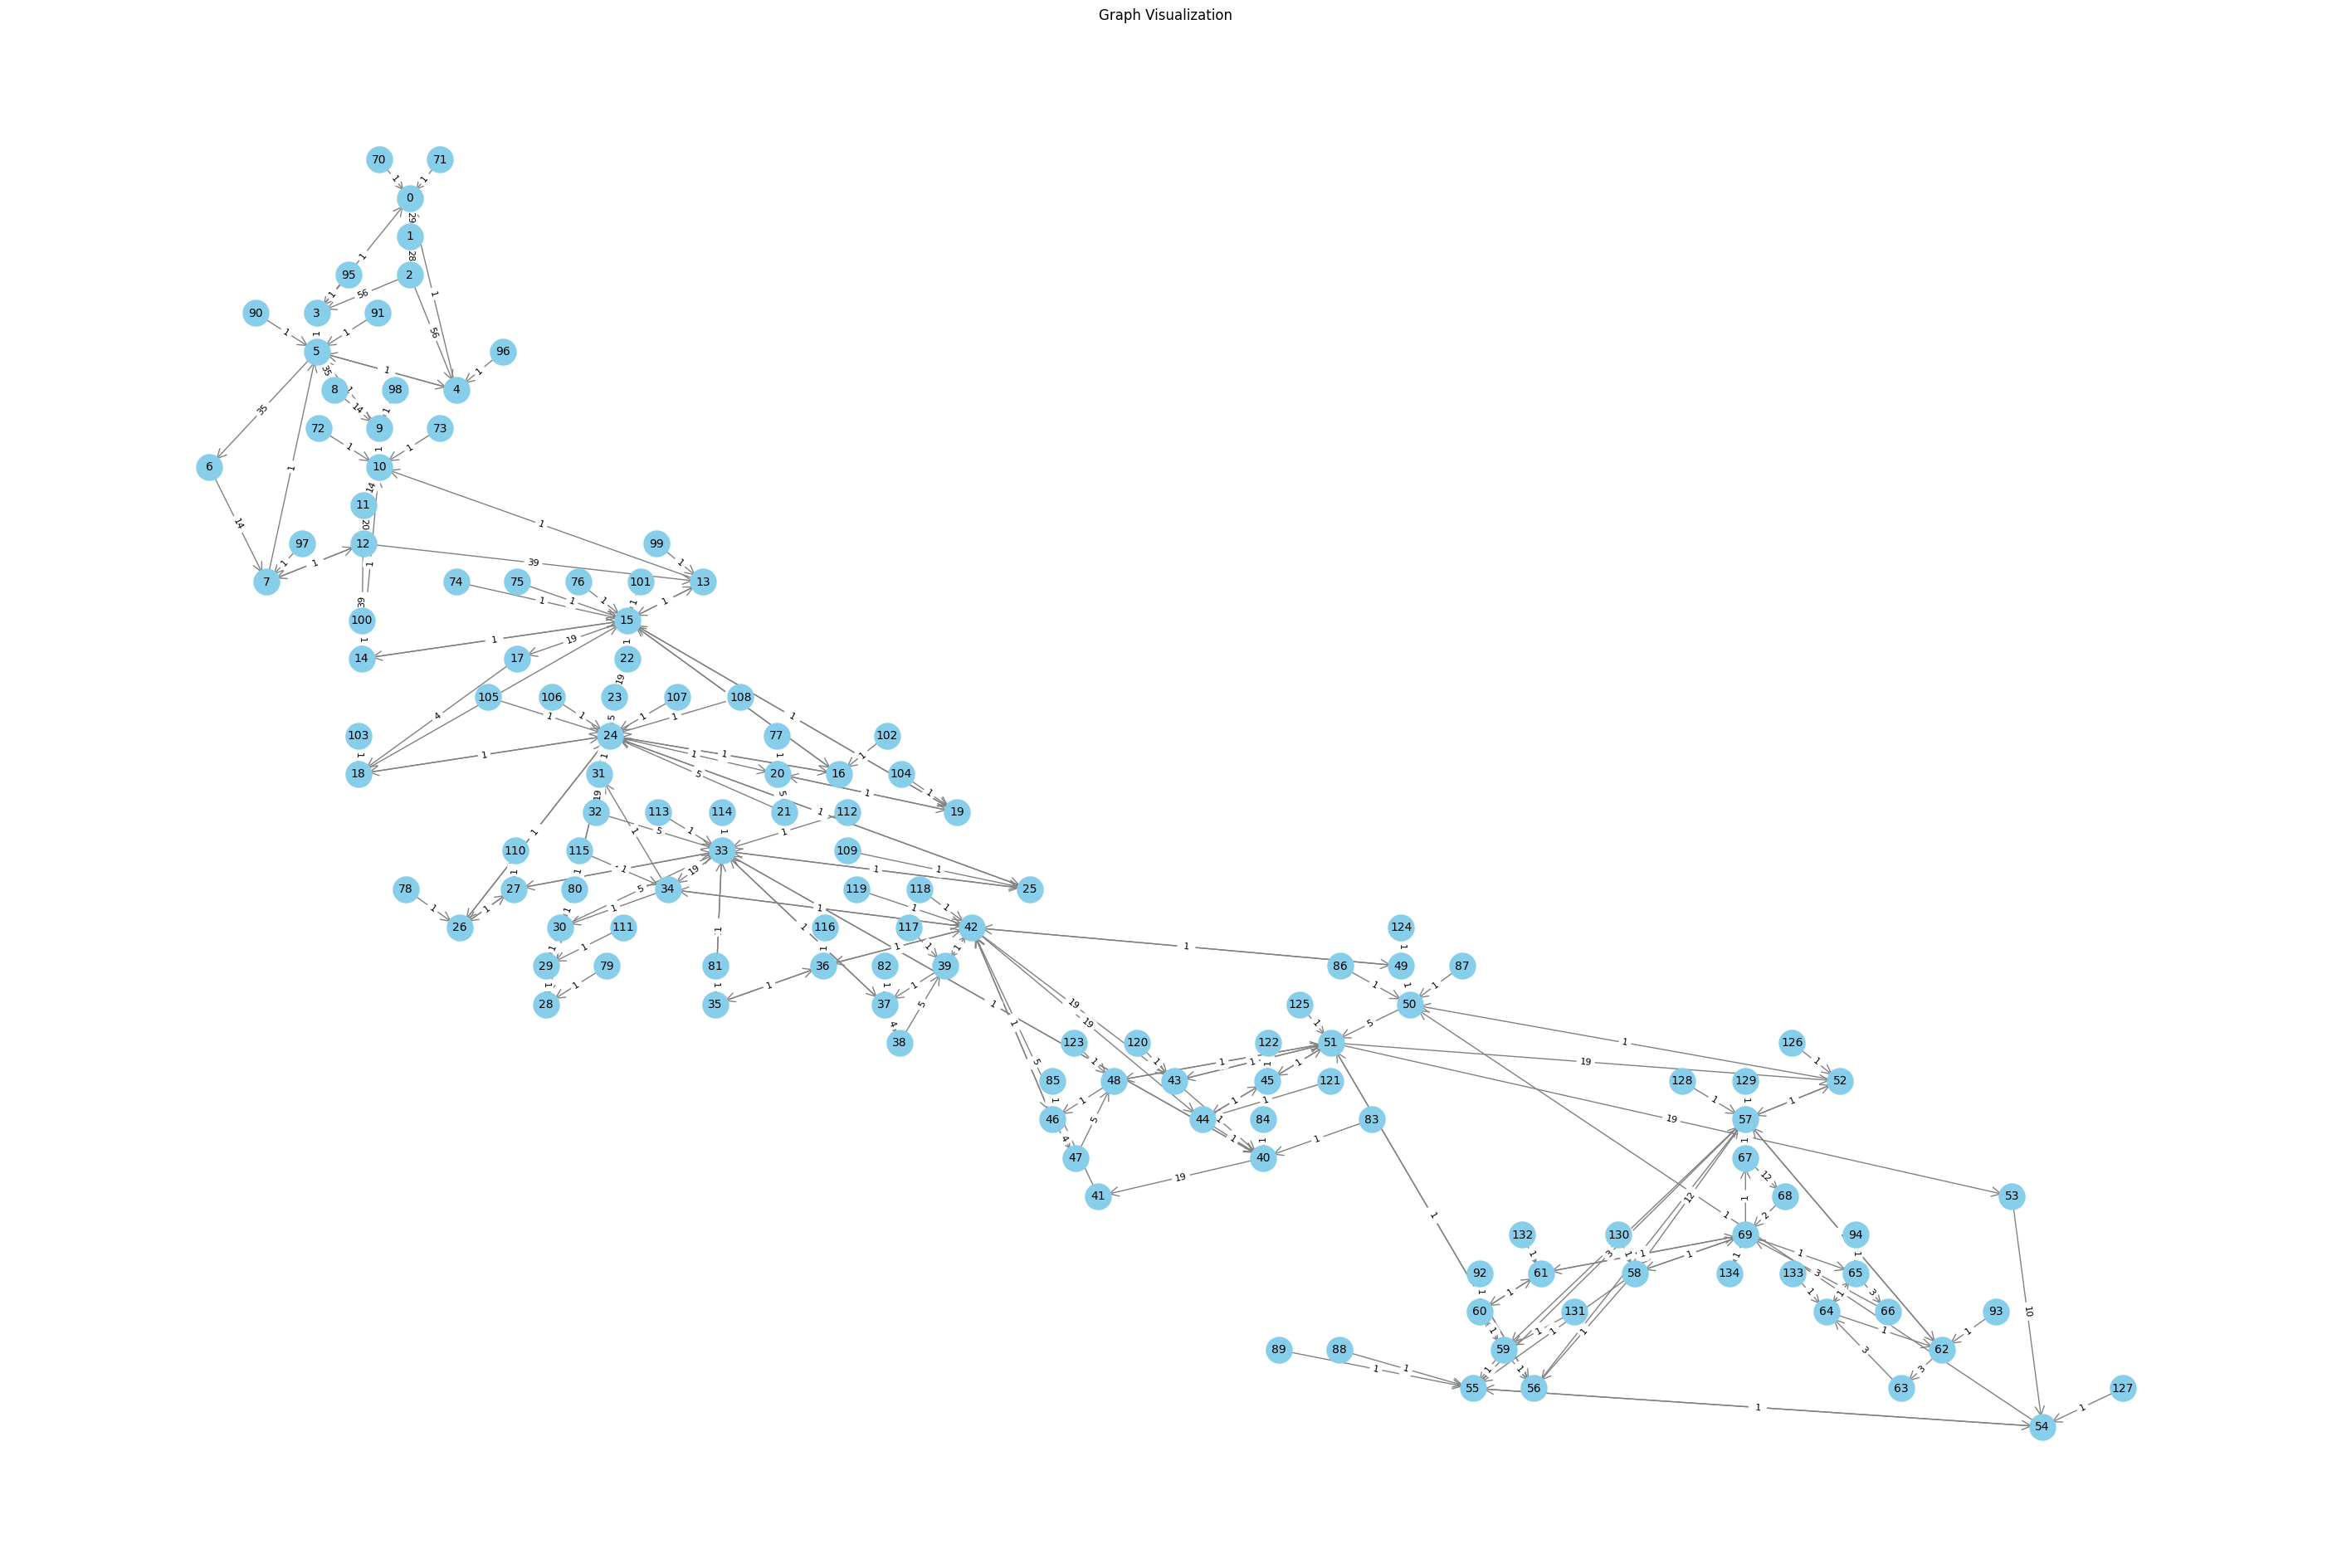

Edge: (0, 1), Attributes: {'flits': 29, 'datatype': 0}
Edge: (1, 2), Attributes: {'flits': 28, 'datatype': 1}
Edge: (2, 3), Attributes: {'flits': 56, 'datatype': 2}
Edge: (2, 4), Attributes: {'flits': 56, 'datatype': 2}
Edge: (3, 5), Attributes: {'flits': 14, 'datatype': 3}
Edge: (3, 0), Attributes: {'flits': 1, 'datatype': 1003}
Edge: (4, 5), Attributes: {'flits': 21, 'datatype': 4}
Edge: (4, 0), Attributes: {'flits': 1, 'datatype': 1004}
Edge: (5, 6), Attributes: {'flits': 35, 'datatype': 5}
Edge: (5, 8), Attributes: {'flits': 35, 'datatype': 5}
Edge: (5, 3), Attributes: {'flits': 1, 'datatype': 1005}
Edge: (5, 4), Attributes: {'flits': 1, 'datatype': 1005}
Edge: (6, 7), Attributes: {'flits': 14, 'datatype': 6}
Edge: (7, 12), Attributes: {'flits': 20, 'datatype': 7}
Edge: (7, 5), Attributes: {'flits': 1, 'datatype': 1007}
Edge: (8, 9), Attributes: {'flits': 14, 'datatype': 8}
Edge: (9, 10), Attributes: {'flits': 14, 'datatype': 9}
Edge: (9, 5), Attributes: {'flits': 1, 'datatype': 10

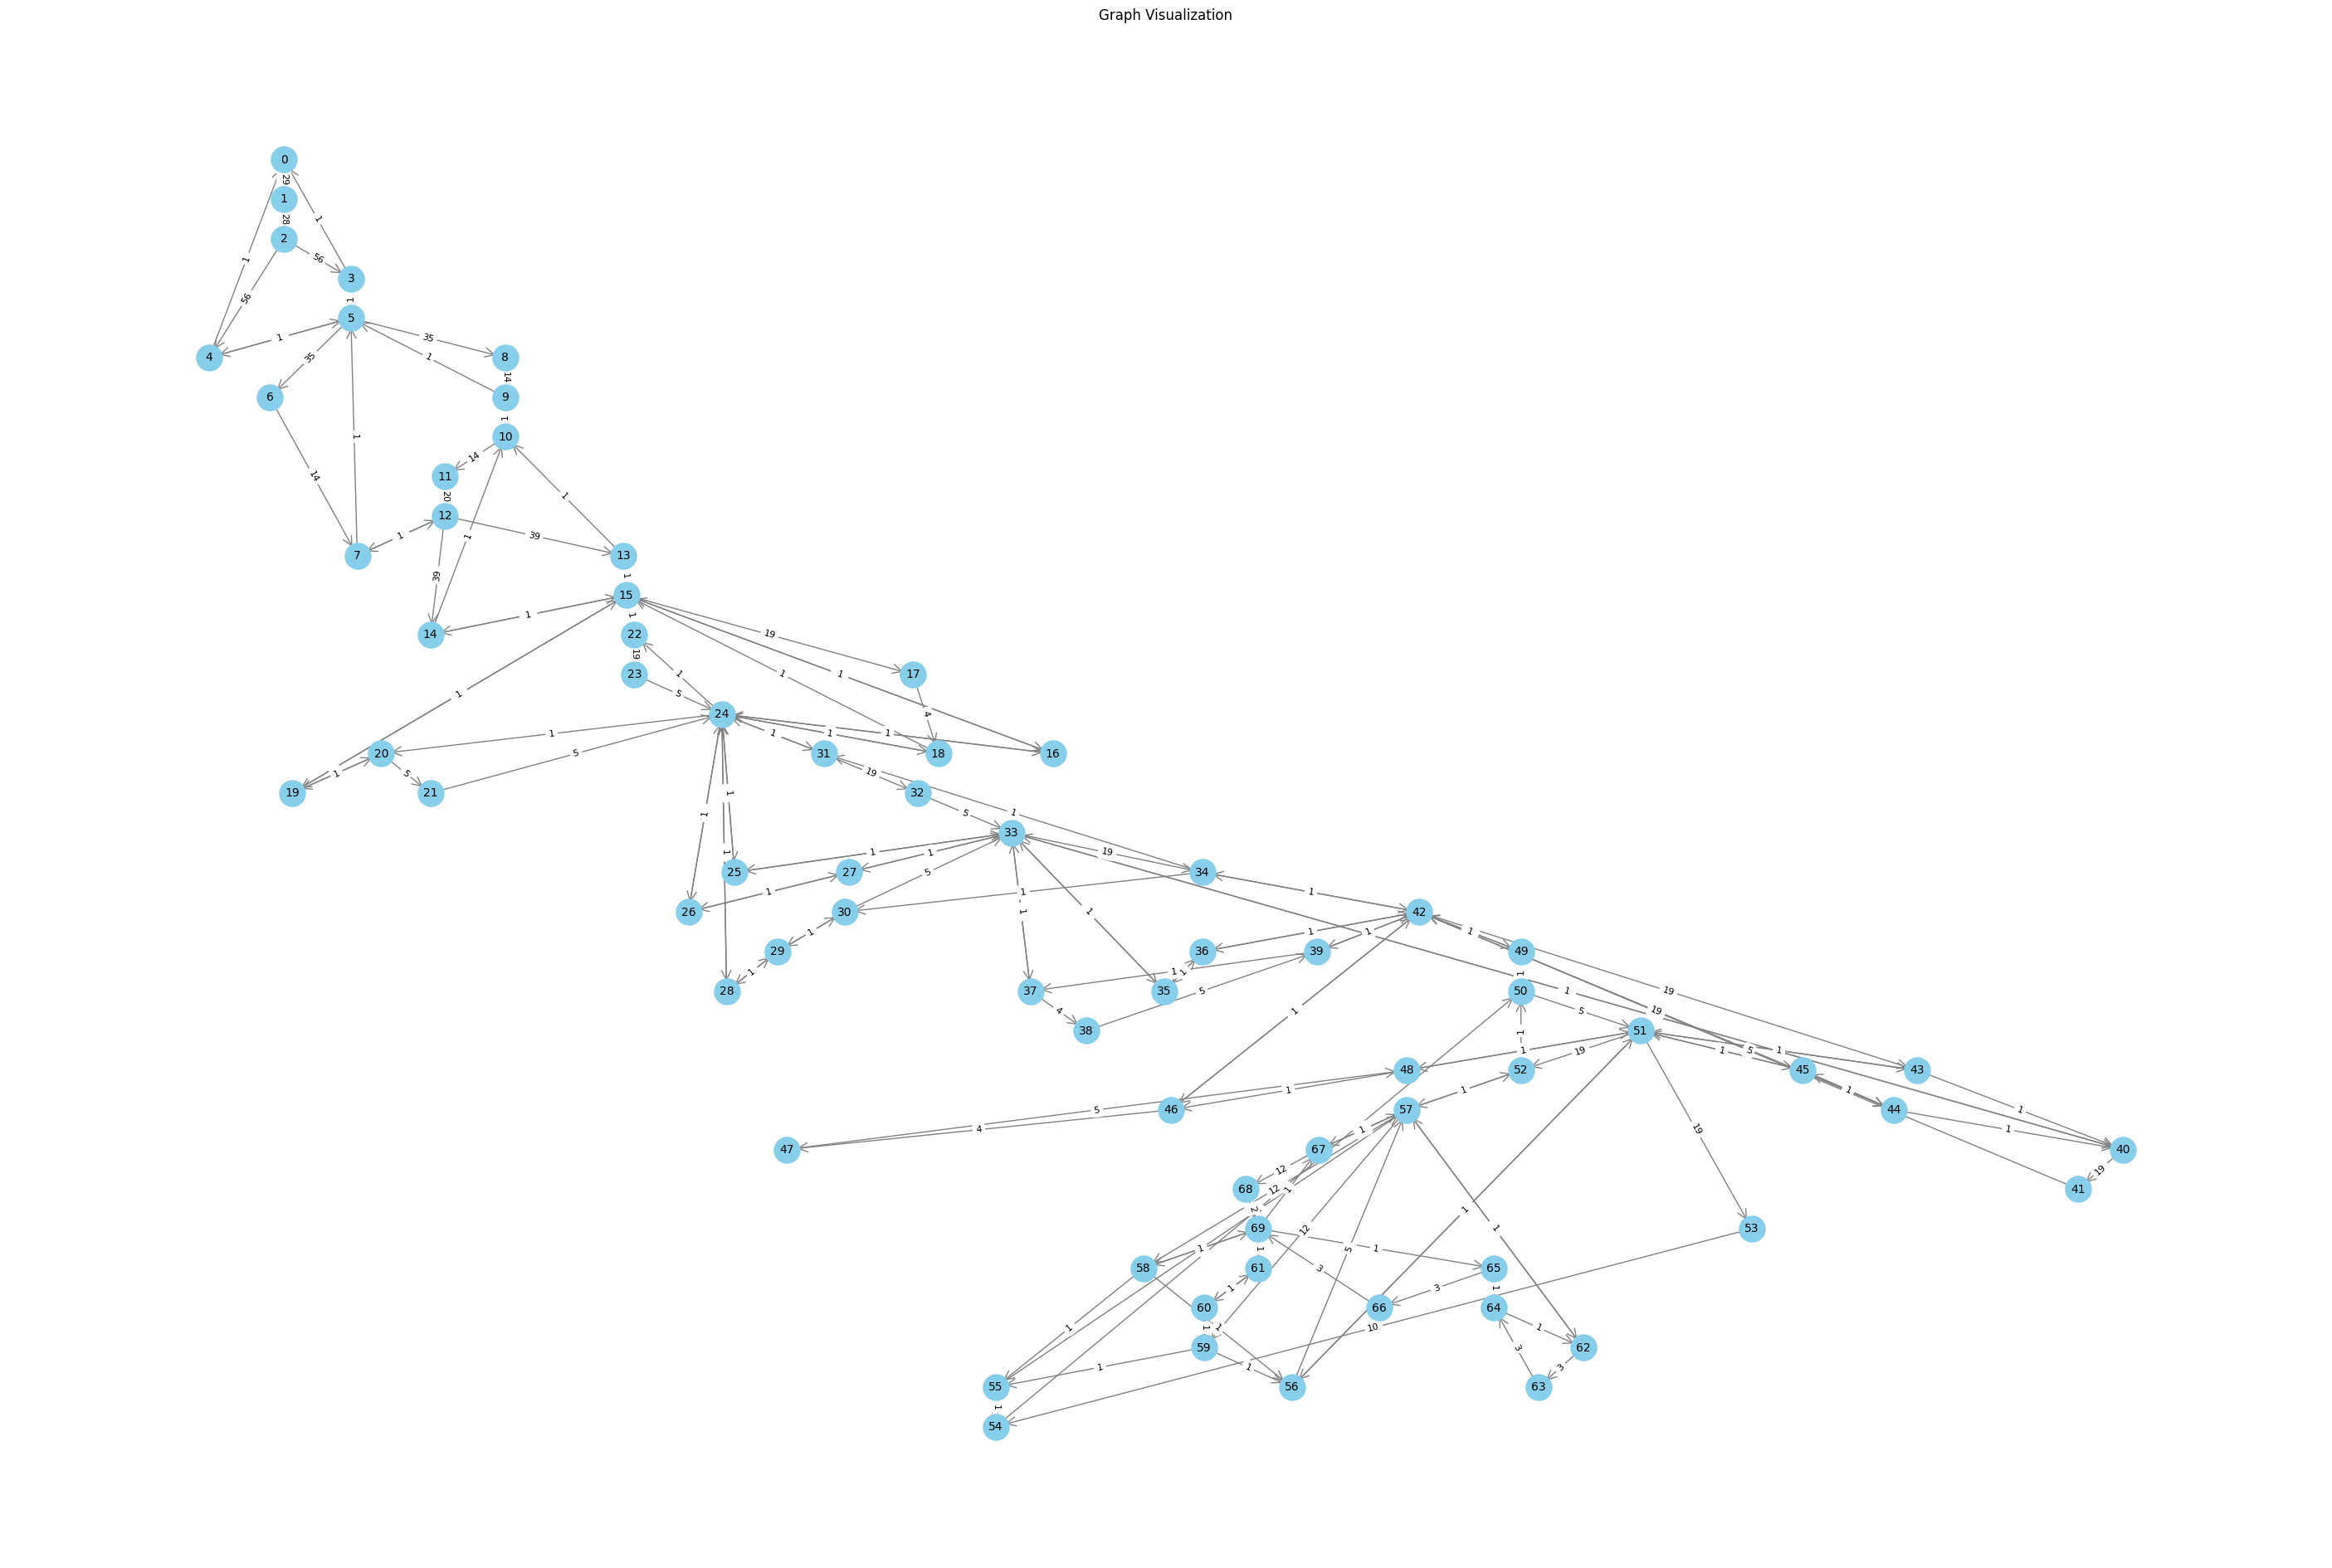

In [23]:
# ======================================================================
# Add feedback edges and init tasks
# ======================================================================



# load the results of the linear programming (mapping + scheduling)
with open("/home/sfischer/Documents/projects/wk_LinProg/LinProg_Scripts/LinProgResults.json", "r") as json_file:
    data = json.load(json_file)


combined_mapping_dict = data["combined_mapping_dict"]
mapping = data["mapping"]
shortest_path = data["shortest_path"]


draw_networkx_graph_color(task_graph,combined_mapping_dict,mapping)
print(mapping)
print(combined_mapping_dict)

for node in task_graph.nodes:
    if "nodetype" not in task_graph.nodes[node]:
        task_graph.nodes[node]["nodetype"] = "default"

    # if "accel" not in task_graph.nodes[node]:
    for key, value in combined_mapping_dict.items():
        # print(node,value)
        if node in value:
            task_graph.nodes[node]["accel"] = key


# for node in task_graph.nodes:
#     print(f"node: {node}")
#     print (task_graph.nodes[node]["accel"])
task_graph_update = task_graph.copy()


init_node_counter=len(task_graph.nodes())
init_dict = {}


# ======================================================================
# Add finishing task
# ======================================================================

# task_graph_update.add_node(init_node_counter, delay_comp=0, delay_mem=0, delay_send=0,nodetype="finish", src=False, dst=False)

# task_graph_update.add_edge(init_node_counter-1, init_node_counter,flits=1,datatype=init_node_counter-1)
# init_node_counter += 1
for u, v, data in task_graph_update.edges(data=True):
    # print(f"Edge: ({u}, {v}), Data before: {data}") # Optional: for debugging
    data["datatype"] = u # Add or update the 'datatype' attribute
        # print(f"Edge: ({u}, {v}), Data after: {data}") # Optional: for debugging
    

task_graph_no_init_tasks = task_graph_update.copy()
created_init_nodes = {}
feedback_counter_inPE={}
# get the needed feedback nodes for each PE
for key, value in combined_mapping_dict.items():
    subset_nodes = value
    all_paths = []
    for src in subset_nodes:
        for dst in subset_nodes:
            if src != dst:
                paths = list(nx.all_simple_paths(task_graph, source=src, target=dst))
                for path in paths:
                    if all(node in subset_nodes for node in path):
                        all_paths.append(path)

    independent_paths = []
    for path in all_paths:
        if not any(set(path).issubset(set(other)) and path != other for other in all_paths):
            independent_paths.append(path)


    print(f"Independent paths for accelerator {independent_paths}:")

    # add feedback edges and init nodes to start the feedback
    for path in independent_paths:
        if path[0] != path[-1]:
            task_graph_update.add_edge(path[-1], path[0],flits=1,datatype=1000+path[-1])
            task_graph_no_init_tasks.add_edge(path[-1], path[0],flits=1,datatype=1000+path[-1],type="feedback")
            feedback_counter_inPE[task_graph.nodes[path[0]]["accel"]]=True

            init_dict[path[0]] = path[-1]
            if path[-1] not in created_init_nodes:
                task_graph_update.add_node(init_node_counter, delay_comp=0, delay_mem=0, delay_send=0,nodetype="init", src=False, dst=False)
                task_graph_update.add_edge(init_node_counter, path[0],flits=1,datatype=1000+path[-1])
                init_node_counter += 1

                created_init_nodes[path[-1]] = init_node_counter
# print("\nEdges and their attributes in task_graph_update:")
# for u, v, data in task_graph_update.edges(data=True):
#     print(f"Edge: ({u}, {v}), Attributes: {data}")
# ======================================================================
# Add feedback edges and init tasks for tasks between accelerators
# task can only start if its destination (if it is in another accelerator) is finished
# ======================================================================

for node in task_graph.nodes:
    for successor in task_graph.successors(node):
        same_accelerator = False
        for key, value_list in combined_mapping_dict.items():
            if node in value_list and successor in value_list:
                
                same_accelerator=True

        if not same_accelerator:
            task_graph_update.add_edge(successor, node, flits=1, datatype=1000+successor)
            task_graph_no_init_tasks.add_edge(successor, node, flits=1, datatype=1000+successor, type="feedback")

            init_dict[node] = successor

            task_graph_update.add_node(init_node_counter, delay_comp=0, delay_mem=0, delay_send=0, nodetype="init", src=False, dst=False)
            
            task_graph_update.add_edge(init_node_counter, node, flits=1, datatype=1000+successor)
            init_node_counter += 1

# ADD final task to know when finished
# print("final node")
# print(list(task_graph_no_init_tasks.nodes)[-1])
final_node = list(task_graph_no_init_tasks.nodes)[-1]

node_list=list(task_graph_update.nodes)
last_node = int(node_list.pop()+1)

task_graph_update.add_node(last_node, delay_comp=0, delay_mem=0, delay_send=0,nodetype="default", src=False, dst=False)
task_graph_update.add_edge(final_node, last_node, flits=1,datatype=last_node)


# task_graph_no_init_tasks.add_edge(19, 99, flits=1,datatype=99)
# task_graph_no_init_tasks.add_node(99, delay_comp=0, delay_mem=0, delay_send=0,nodetype="default", src=False, dst=False)

draw_networkx_graph(task_graph_update)
for u, v, data in task_graph_update.edges(data=True):
    print(f"Edge: ({u}, {v}), Attributes: {data}")
draw_networkx_graph(task_graph_no_init_tasks)
# save updated graph with feedback
with open('/home/sfischer/Documents/projects/wk_LinProg/LinProg_Scripts/task_graph_feedback.pkl', 'wb') as output_file:
    pickle.dump(task_graph_update, output_file)

with open('/home/sfischer/Documents/projects/wk_LinProg/LinProg_Scripts/task_graph_NoInit.pkl', 'wb') as output_file:
    pickle.dump(task_graph_no_init_tasks, output_file)


In [24]:
data_writer = writers.DataWriter('data')
data_writer.add_dataTypes_node(range(len(task_graph.nodes)))


In [25]:
# ======================================================================
# Convert the networkx graph to the XML format
# ======================================================================
print(task_graph_update,task_graph_no_init_tasks)

task_graph_list=[task_graph_update,task_graph_no_init_tasks]

for index, task_graph in enumerate(task_graph_list):
    data_writer = writers.DataWriter('data')
    data_writer.add_dataTypes_node(range(len(task_graph.nodes)))
    tasks_node = data_writer.add_tasks_node()

    node_list=list(task_graph.nodes)

    if index == 0:
        
        last_node = node_list.pop()
        node_list.insert(0, last_node)

    for node in node_list:
        atr=task_graph.nodes[node]
        task_node = data_writer.add_task_node(tasks_node, t_id=node,duration=(1,1), repeat=(10,10))

        generates_node = data_writer.add_generates_node(task_node)
        successors = list(task_graph.successors(node))
        # print("successor of node: ", node)
        # print("successors: ", successors)
        seen_accels = set()
        unique_successors = []
        for suc in successors:
            accel = task_graph.nodes[suc].get('accel', 'Not defined')
            edge_datatype = task_graph.edges[node, suc].get("datatype", 0)
            print(f"DEBUG: Edge (node, suc) ({node}, {suc}) has datatype: {edge_datatype}")
            if (edge_datatype,accel) not in seen_accels:
                seen_accels.add((edge_datatype,accel))
                unique_successors.append(suc)
            else:
                print(f"Duplicate successor removed: {suc} with Accel: {accel}")
        
        successors = unique_successors  # Update successors list with unique values

        # print("successor of node: ", node)
        # print("successors: ", successors)
        # if atr["nodetype"] == "init":
        #     dist_tasks=[task_graph.edges[node, successors[0]]["datatype"]]
        # else:
        dist_tasks=[]
        for i in successors:
            print("successor of node: ", node , i)
            print(task_graph.edges[node, i]["datatype"])
            dist_tasks.append(task_graph.edges[node, i]["datatype"])
            # dist_tasks = [node] * len(successors)



        count_list = [] 
        for suc in successors:
            count_list.append(task_graph.edges[node, suc]["flits"])
        # if len(successors) > 0:

        data_writer.add_possibility(generates_node, id=0, prob=1, delay=(atr["delay_comp"],atr["delay_comp"]), interval=20, count=count_list, dt_ix=dist_tasks, dist_tasks=successors)

        predecessors = list(task_graph.predecessors(node))
        if len(predecessors) > 0:
            requires_node = data_writer.add_requires_node(task_node)
        for idx,pre in enumerate(predecessors):
            pre_atr = task_graph.nodes[pre]
            count_req = task_graph.edges[pre, node]["flits"]
            if pre_atr["nodetype"] != "init":
                data_writer.add_requirement(requires_node,id=idx, type=task_graph.edges[pre, node]["datatype"], source=pre, count=count_req)

    print("\nEdges and their attributes in task_graph_update:")
    for u, v, data in task_graph_update.edges(data=True):
        print(f"Edge: ({u}, {v}), Attributes: {data}")
    
    if index == 0:
        identifier = ""
    elif index == 1:
        identifier = "NoInit"
    data_writer.write_file(f'../XML/LinProg_test/data{identifier}.xml')

DiGraph with 135 nodes and 223 edges DiGraph with 70 nodes and 158 edges
DEBUG: Edge (node, suc) (0, 1) has datatype: 0
successor of node:  0 1
0
DEBUG: Edge (node, suc) (1, 2) has datatype: 1
successor of node:  1 2
1
DEBUG: Edge (node, suc) (2, 3) has datatype: 2
DEBUG: Edge (node, suc) (2, 4) has datatype: 2
Duplicate successor removed: 4 with Accel: 0
successor of node:  2 3
2
DEBUG: Edge (node, suc) (3, 5) has datatype: 3
DEBUG: Edge (node, suc) (3, 0) has datatype: 1003
successor of node:  3 5
3
successor of node:  3 0
1003
DEBUG: Edge (node, suc) (4, 5) has datatype: 4
DEBUG: Edge (node, suc) (4, 0) has datatype: 1004
successor of node:  4 5
4
successor of node:  4 0
1004
DEBUG: Edge (node, suc) (5, 6) has datatype: 5
DEBUG: Edge (node, suc) (5, 8) has datatype: 5
Duplicate successor removed: 8 with Accel: 5
DEBUG: Edge (node, suc) (5, 3) has datatype: 1005
DEBUG: Edge (node, suc) (5, 4) has datatype: 1005
Duplicate successor removed: 4 with Accel: 0
successor of node:  5 6
5
su